In [1]:
plt.style.use('bmh')
# plt.style.use('ggplot')
# plt.style.use('seaborn')
# plt.style.use('default')
# plt.style.use('fivethirtyeight')

### Mainheat description

#### 1. Read datasets

In [2]:
# Read clean dataset
feats = [
    'Property_UPRN',
    'Current energy efficiency rating',
    'Total current energy costs over 3 years (£)',
    'CO2 Emissions Current Per Floor Area (kg.CO2/m²/yr)'
]
df0 = pd.read_csv('data/data_clean.csv')[feats]
# create rating
df0['CO2_rating'] = pd.qcut(df0[feats[-1]], q = 5, labels = range(1,6)).astype(int)
df0['CO2_rating'] = 6 - df0.CO2_rating
display(df0.CO2_rating.value_counts().sort_index())

1    36938
2    34265
3    37728
4    37016
5    39092
Name: CO2_rating, dtype: int64

In [3]:
# read preprocessed dataset
df1 = pd.read_csv('data/descriptions/MAINHEAT_DESCRIPTION.csv', sep = '|')
# ratings convertion and merge with initial dataset
dict_repl1 = {
    'very poor': 1,
    'poor': 2,
    'average': 3,
    'good': 4,
    'very good': 5,
}
df1['Mainheat_rating'] = df1['MAINHEAT_ENERGY_EFF'].str.lower().map(dict_repl1)
df1 = df1.merge(df0, on = 'Property_UPRN', how = 'left')
df1['Total_rating'] = (df1.Mainheat_rating + df1.CO2_rating)/2
print(df1.shape)
display(df1.Total_rating.value_counts().sort_index())

(186485, 10)


1.00     6471
1.50     4568
2.00    16456
2.50    18406
3.00    31134
3.50    36727
4.00    35325
4.50    35855
5.00     1543
Name: Total_rating, dtype: int64

#### 2. Data cleaning

In [4]:
df1['MAINHEAT_DESCRIPTION'] = df1.MAINHEAT_DESCRIPTION.map(lambda x: x.replace('&amp;','and').replace('And','and'))

In [5]:
df1['MAINHEAT_TYPE'] = df1.MAINHEAT_DESCRIPTION.map(lambda x: x.split(',')[0].strip())

In [6]:
df1.MAINHEAT_TYPE.value_counts().sort_index().to_dict()

{'Air source heat pump': 6265,
 'Boiler': 35,
 'Boiler and radiators': 150604,
 'Boiler and underfloor': 105,
 'Boiler and underfloor heating': 971,
 'Community scheme': 4605,
 'Electric ceiling heating': 19,
 'Electric storage heaters': 14206,
 'Electric underfloor heating': 194,
 'Ground source heat pump': 331,
 'No system present: electric heaters assumed': 680,
 'Portable electric heaters assumed for most rooms': 68,
 'Room heaters': 8164,
 'Warm air': 228,
 'Water source heat pump': 10}

In [7]:
dict_repl = {
 'Air source heat pump':          'Air source heat pump',
 'Boiler':                        'Boiler and radiators',
 'Boiler and radiators':          'Boiler and radiators',
 'Boiler and underfloor':         'Boiler and underfloor',
 'Boiler and underfloor heating': 'Boiler and underfloor',
 'Community scheme':            'Community scheme',
 'Electric ceiling heating':    'Electric heaters',
 'Electric storage heaters':    'Electric heaters',
 'Electric underfloor heating': 'Electric heaters',
 'Ground source heat pump':     'Other',
 'No system present: electric heaters assumed':      'Electric heaters',
 'Portable electric heaters assumed for most rooms': 'Electric heaters',
 'Room heaters': 'Room heaters',
 'Warm air':     'Other',
 'Water source heat pump': 'Other'
}
df1['MAINHEAT_TYPE'] = df1.MAINHEAT_TYPE.map(dict_repl)

In [8]:
df1[:3]

,MAINHEAT_DESCRIPTION,MAINHEAT_ENERGY_EFF,MAINHEAT_ENV_EFF,Property_UPRN,Mainheat_rating,Current energy efficiency rating,Total current energy costs over 3 years (£),CO2 Emissions Current Per Floor Area (kg.CO2/m²/yr),CO2_rating,Total_rating,MAINHEAT_TYPE
0,"Boiler and radiators, mains gas",Good,Good,1001100841,4,53.00,"3,789.00",66.00,1,2.50,Boiler and radiators
1,"Boiler and radiators, mains gas",Good,Good,1001950838,4,66.00,"4,635.00",44.00,3,3.50,Boiler and radiators
2,Electric storage heaters,Average,Very Poor,1000995515,3,61.00,"3,570.00",68.00,1,2.00,Electric heaters


#### 3. Ratings vizualisation

In [9]:
feats_gr = ['MAINHEAT_TYPE']
feats_ag = ['Mainheat_rating', 'CO2_rating', 'Total_rating']
colors_list = ['red','orange','green']

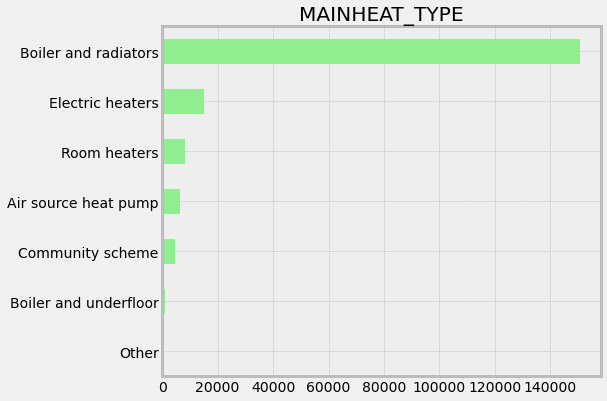

In [10]:
# popularity by wall types and insulation
_, ax = plt.subplots(1,1, figsize = (7,6))
_ = df1.groupby(feats_gr[0]).size().sort_values().plot(kind = 'barh', ax = ax, ylabel = '', color = 'lightgreen', title = 'MAINHEAT_TYPE')

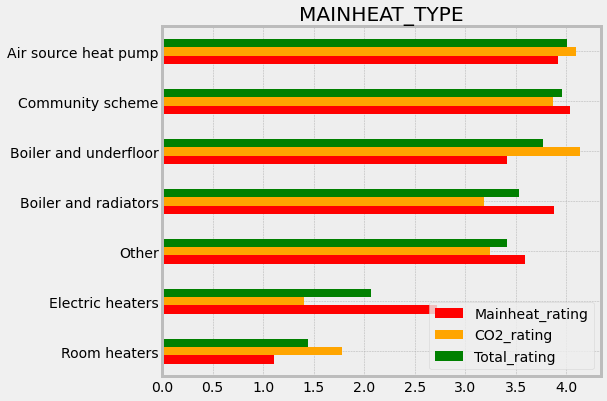

In [11]:
# ratings by wall types and insulation
_, ax = plt.subplots(1,1, figsize = (7,6))
_ = df1.groupby(feats_gr[0])[feats_ag].mean().sort_values('Total_rating').plot(kind = 'barh', ax = ax, ylabel = '', color = colors_list, title = 'MAINHEAT_TYPE')

#### 4. Correlations algorithm

In [12]:
# 1) create splittings
feats_gr = [
    'MAINHEAT_TYPE', 
    'Mainheat_rating'
]
feats_ag = [
    'Current energy efficiency rating',
    'Total current energy costs over 3 years (£)',
    'CO2 Emissions Current Per Floor Area (kg.CO2/m²/yr)'
]
           
df2 = df1.groupby(feats_gr)[feats_ag[-1]].agg([len,np.mean]).reset_index()
df2['group_name'] = df2[feats_gr].apply(lambda x: '_'.join([str(x1) for x1 in x]), axis = 1)
df2.loc[df2['len'] < 100, 'group_name'] = '_OTHER'
del df2['len']
del df2['mean']
print(df2.shape)

# merge with initial dataset
df1 = df1.merge(df2, how = 'left', on = feats_gr)

(28, 3)


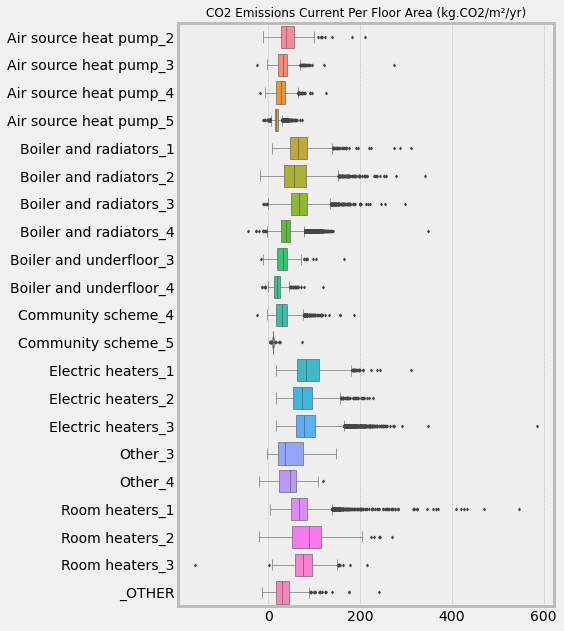

In [13]:
# 2) Plot boxplot to visually compare distributions
list_groups = sorted(df1[~df1.group_name.isnull()].group_name.unique())
feat = feats_ag[-1]
_, ax = plt.subplots(1,1, figsize = (6,10))
p = sns.boxplot(y=df1.group_name, x=df1[feat], ax = ax, order = list_groups, linewidth=0.5, saturation=1, fliersize = 2)
_ = p.set_title(feat, fontsize = 12)
_ = p.set_ylabel('')
_ = p.set_xlabel('')

In [14]:
# 3) Conduct ANOVA statistical test to have numerical value of similarity between these variables.
from scipy import stats
data = df1.groupby('group_name')[feat].agg(lambda x: list(x))
fvalue, pvalue = stats.f_oneway(*data)
fvalue, pvalue

(5124.222255511173, 0.0)

#### 5. Feature engineering for modelling part
- Calculate average values of features Current energy efficiency rating and Total current energy costs over 3 years (£) by the groups that described above.
- Create new features on the Property_UPRN level and replace the categorical features by that new numericals.
- We will use that features in the modelling part.

In [15]:
# Calculate average values of features Current energy efficiency rating and Total current energy costs over 3 years (£) by the groups.
pre = 'Mainheat_'
df2 = df1.groupby(feats_gr)[feats_ag[:-1]].agg([len, np.mean])
df2.columns = [pre+'eff_len',pre+'eff_mean',pre+'cost_len',pre+'cost_mean']
df2.reset_index(inplace = True)
df2['group_name'] = df2[feats_gr].apply(lambda x: '_'.join([str(x1) for x1 in x]), axis = 1)
df2.loc[df2[pre+'eff_len'] < 100, 'group_name'] = '_OTHER'
del df2[pre+'eff_len']
del df2[pre+'cost_len']

In [16]:
# Create new features on the Property_UPRN level and replace the categorical features by that new numericals
df2 = df2.groupby('group_name')[pre+'eff_mean',pre+'cost_mean'].mean().reset_index()
df1 = df1.merge(df2)
df3 = df1.groupby('Property_UPRN')[pre+'eff_mean',pre+'cost_mean'].mean().reset_index()

In [17]:
# We will use that features in the modelling part.
df3.to_csv('data/features/MAINHEAT_DESCRIPTION.csv', index = False, encoding = 'utf8', sep = '|')